## Домашнее задание №8

В данном задании вам предстоит детально рассмотреть механизм Attention (и реализовать несколько его вариантов), а также вернуться к задаче классификации текстов из задания №6 и решить ее с использованием BERT.

In [1]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
%matplotlib inline

### Шаг №1. Реализация Attention

В данной задаче вам предстоит реализовать механизм Attention, в частности несколько способов подсчета attention scores. Конечно, в популярных фреймворках данный механизм уже реализован, но для лучшего понимания вам предстаит реализовать его с помощью `numpy`.

Ваше задание в данной задаче: реализовать `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты Attention. Для вашего удобства (и для примера) `dot product` attention (основанный на скалярном произведении) уже реализован.

Детальное описание данных типов Attention доступно в лекционных слайдах.

Text(0.5, 1.0, 'Decoder state')

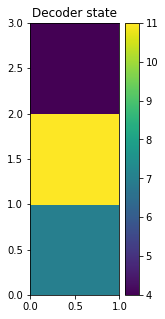

In [2]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

#### Dot product attention (пример реализации)
Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3`:

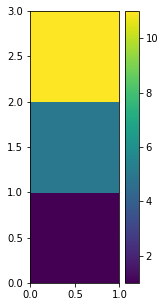

In [3]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Attention score между данными состояниями энкодера и декодера вычисляются просто как скалярное произведение:

In [4]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

В общем случае состояний энкодера, конечно, несколько. Attention scores вычисляются с каждым из состояний энкодера:

In [5]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]
    
]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Тогда для подсчета скалярных произведений между единственным состоянием декодера и всеми состояниями энкодера можно воспользоваться следующей функцией (которая по факту представляет собой просто матричное умножение и приведение типов):

In [6]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [7]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

Для подсчета "весов" нам необходим Softmax:

In [8]:
def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max()
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

In [9]:
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

Наконец, воспользуемся данными весами и вычислим итоговый вектор, как и описано для dot product attention.

[[ 8.]
 [12.]
 [ 2.]]


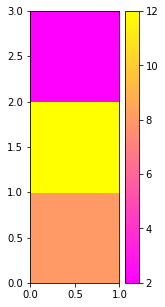

In [10]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap='spring')
plt.colorbar()

Данный вектор аккумулирует в себе информацию из всех состояний энкодера, взвешенную на основе близости к заданному состоянию декодера.

Реализуем все вышеописанные преобразования в единой функции:

In [11]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [12]:
assert (attention_vector == dot_product_attention(decoder_hidden_state, encoder_hidden_states)).all()

#### Multiplicative attention
Ваша текущая задача: реализовать multiplicative attention.
$$ e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i $$

Матрица весов `W_mult` задана ниже. 
Стоит заметить, что multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, поэтому состояния энкодера будут обновлены:

In [13]:
encoder_hidden_states = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
    
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

In [14]:
# your code here

def mult_attention_score(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''

    v1 = np.dot(decoder_hidden_state.T, W_mult)
    attention_scores = np.dot(v1, encoder_hidden_states)

    return attention_scores

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `multiplicative_attention`:

In [15]:
def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_dec, n_features_enc)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # your code here
    
    v1 = np.dot(decoder_hidden_state.T, W_mult)
    attention_scores = np.dot(v1, encoder_hidden_states)

    softmax_vector = softmax(attention_scores)
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T

    return attention_vector

In [16]:
v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

In [17]:
# your code here

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.],
       [ 4.,  2., 11.,  8.],
       [-4.,  2.,  5., 12.]])

#### Additive attention
Теперь вам предстоит реализовать additive attention.

$$ e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s}) $$

Матрицы весов `W_add_enc` и `W_add_dec` доступны ниже, как и вектор весов `v_add`. Для вычисления активации можно воспользоваться `np.tanh`.

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `additive_attention`:

In [18]:
def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    # your code here

    sum1 = np.matmul(W_add_enc, encoder_hidden_states)
    sum2 = np.matmul(W_add_dec, decoder_hidden_state)
    sum = sum1 + sum2

    tan = np.tanh(sum)
    attention_scores = np.dot(v_add.T, tan)

    softmax_vector = softmax(attention_scores)
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T

    return attention_vector

In [19]:
encoder_hidden_states = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
    
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

In [20]:
decoder_hidden_state

array([[ 7.],
       [11.],
       [ 4.]])

In [21]:
x = additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec)
x

array([[4.64510711],
       [6.6372749 ],
       [3.11601386],
       [6.2104178 ],
       [3.06285127]])

In [22]:
y = multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult)
y

array([[-9.00000000e+00],
       [ 1.01553049e-19],
       [ 1.00000000e+00],
       [ 8.00000000e+00],
       [ 1.20000000e+01]])

Сдайте функции `multiplicative_attention` и `additive_attention` в контест.

Не забудьте про импорт `numpy`!

### Шаг №2 (опциональный). Классификация текстов с использованием предобученной языковой модели.

Вновь вернемся к набору данных SST-2. Разобьем выборку на train и test аналогично заданию №6.

In [23]:
# do not change the code in the block below
# __________start of block__________

!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
# __________end of block__________

--2022-12-18 21:02:59--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw08_attention/holdout_texts08.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45416 (44K) [application/octet-stream]
Saving to: ‘holdout_texts08.npy’

holdout_texts08.npy 100%[===================>]  44.35K  --.-KB/s    in 0.01s   

2022-12-18 21:03:00 (3.69 MB/s) - ‘holdout_texts08.npy’ saved [45416/45416]



In [24]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)

texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]
texts_holdout = np.load('holdout_texts08.npy', allow_pickle=True)

# __________end of block__________

In [25]:
texts_train

array(['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films',
       'apparently reassembled from the cutting room floor of any given daytime soap',
       "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",
       ..., 'samuel l jackson is one of the best actors there is',
       'it does give a taste of the burning man ethos , an appealing blend of counter cultural idealism and hedonistic creativity',
       "a plethora of engaging diatribes on the meaning of ` home , ' delivered in grand passion by the members of the various households"],
      dtype=object)

Весь остальной код предстоит написать вам.

Для успешной сдачи на максимальный балл необходимо добиться хотя бы __84.5% accuracy на тестовой части выборки__.

In [26]:
# your beautiful experiments here

In [27]:
!pip install -Uqq transformers

     |████████████████████████████████| 5.8 MB 3.7 MB/s 
     |████████████████████████████████| 182 kB 63.2 MB/s 
     |████████████████████████████████| 7.6 MB 8.5 MB/s 


In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [29]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel,
    ppb.DistilBertTokenizer,
    'distilbert-base-uncased'
)

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
batch = df
tokenized = batch[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

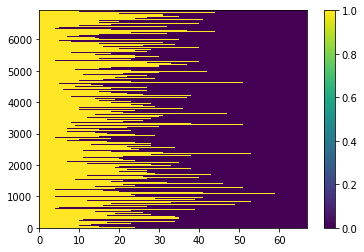

In [31]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

plt.pcolormesh(padded>0)
plt.colorbar()

In [32]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(6920, 67)

In [33]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

np.shape(input_ids)

torch.Size([6920, 67])

In [34]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#ids_loader = DataLoader(input_ids, batch_size=64, shuffle=False)
#mask_loader = DataLoader(attention_mask, batch_size=64, shuffle=False)

dataset = TensorDataset(input_ids, attention_mask)

dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

features = []

for i, (ids, mask) in enumerate(dataloader):
  model.eval()
  with torch.no_grad():
    last_hidden_state = model(ids.to(device), attention_mask=mask.to(device))
    feature = last_hidden_state[0][:,0,:].cpu().numpy()

    features.extend(feature)

In [35]:
len(features)

6920

In [36]:
labels = df[1]

len(labels)

6920

In [39]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size=5000)

In [84]:
texts_holdout = np.load('holdout_texts08.npy', allow_pickle=True)

val = texts_holdout
val = pd.Series(val)
tokenized_val = val.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized_val.values:
    if len(i) > max_len:
        max_len = len(i)

padded_val = np.array([i + [0]*(max_len-len(i)) for i in tokenized_val.values])
attention_mask_val = np.where(padded_val != 0, 1, 0)
attention_mask_val.shape

input_ids_val = torch.tensor(padded_val)  
attention_mask_val = torch.tensor(attention_mask_val)

print(len(attention_mask_val))


500


In [93]:
model.eval()
with torch.no_grad():
  val_last_hidden_state = model(input_ids_val, attention_mask=attention_mask_val)
  val_features = last_hidden_state[0][:,0,:].cpu().numpy()

In [90]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [91]:
len(val_last_hidden_state[0][0][0])

768

In [98]:
train = np.array(train_features)

print(train.shape)
print(len(test_features))
print(len(val_features))

(5000, 768)
1920
8


In [75]:
a = np.array(train_features)
a[1][0]

-0.16123348

In [44]:
lr_clf.score(train_features, train_labels)

0.8808

In [83]:
lr_clf.score(test_features, test_labels)

0.8333333333333334

#### Сдача взадания в контест
Сохраните в словарь `out_dict` вероятности принадлежности к нулевому и первому классу соответственно:

In [ ]:
out_dict = {
    'train': train_features
    'test': test_features
    'holdout': # np.array of size (500, 2) with probas
}

Несколько `assert`'ов для проверки вашей посылки:

In [ ]:
assert isinstance(out_dict['train'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['train'].shape == (5000, 2), 'The predicted probas shape does not match the train set size'
assert np.allclose(out_dict['train'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the objects'

assert isinstance(out_dict['test'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['test'].shape == (1920, 2), 'The predicted probas shape does not match the test set size'
assert np.allclose(out_dict['test'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

assert isinstance(out_dict['holdout'], np.ndarray), 'Dict values should be numpy arrays'
assert out_dict['holdout'].shape == (500, 2), 'The predicted probas shape does not match the holdout set size'
assert np.allclose(out_dict['holdout'].sum(axis=1), 1.), 'Probas do not sum up to 1 for some of the object'

Запустите код ниже для генерации посылки и сдайте файл `submission_dict_hw08.npy`.

In [ ]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_hw08.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_hw08.npy`')
# __________end of block__________

На этом задание завершено. Поздравляем!